# SMAI Assignment - 3

## Question - `1` : Support Vector Machines

| | |
|- | -|
| Course | Statistical Methods in AI |
| Release Date | `09.03.2023` |
| Due Date | `24.03.2023` |

This section is divided into 2 subsections.


*   In the first subsection, you will work on a synthetic dataset and visualize the boundary predicted by SVM. You will also vary the value of C-parameter and see how the decision boundary changes. **Please note that you cannot use inbuilt sklearn function for SVM in this sub-section**. You can only use a QCQP (Quadratically Constrained Quadratic Program) solver like CVXPY. 

  References which you may find helpful for this subsection: 
  
  1.   https://www.cvxpy.org/
  2.   https://www.cvxpy.org/examples/basic/quadratic_program.html

  Note that in this section you are expected to show how you derived the Quadratically Constrained form(which can be passed into the solver) from the basic principles of SVM algorithm
*  In the second subsection you will use be using the famous MNIST dataset to explore various kernels and report the results. **Please note you may use inbuilt sklearn SVM functions in this subsection**


In [1]:
# !pip install numpy
# !pip install matplotlib
# !pip install cvxpy
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

### Subsection 1

In [2]:
# Helper function to visualize 2D points X with labels +1(Red) or -1(blue)
def plot_points(X, Y):
    reds = []
    blues = []
    for i in range(Y.shape[0]):
        if Y[i] == 1:
            reds.append(X[i])
        else:
            blues.append(X[i])
    reds = np.array(reds)
    blues = np.array(blues)
    plt.scatter(reds[:, 0], reds[:, 1], c = 'r')
    plt.scatter(blues[:, 0], blues[:, 1], c = 'b')

(16, 2) (16,)


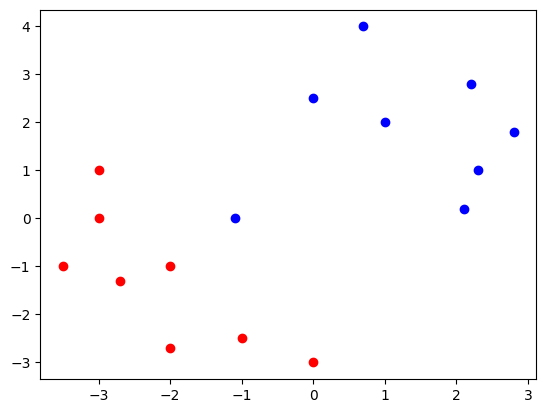

In [3]:
# Create Synthetic Data and visualize the points
X = np.array([[-3.5, -1], [-3, 0], [-3, 1], [-2.7, -1.3], [-2, -1], [-2, -2.7], 
              [-1, -2.5], [0, -3], [-1.1, 0], [0, 2.5], [1, 2], [0.7, 4], 
              [2.1, 0.2], [2.3, 1], [2.8, 1.8], [2.2, 2.8]])
y = np.array([1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1])
print(X.shape,y.shape)
plot_points(X, y)
plt.show()

In the next cell you are required to find the Quadratic Constrained Quadratic form of SVM **without soft constraints** from the basic principles (check the svm slides uploaded in the portal). Start with the idea that SVM tries to maximize the margin and then derive the form which you can feed to the solver.

Please print the values of w, b. 

**Note: You are also required to upload a page of the derivation. You may also type it in markdown here**

**Note: You cannot use sklearn SVM functions here**

#### Derivation
To minimize $||w||^2$ subject to the constraints that all training examples lie on the correct side of the hyperplane, we solve the following quadratic constrained optimization problem:

\begin{align*}
& \min_{w,b} \frac{1}{2} ||w||^2 \
& \text{subject to } y_i(w \cdot x_i + b) \geq 1 \text{ for all } i,
\end{align*}

where $w$ is the weight vector, $x$ is the input data vector, $b$ is the bias term, and $y_i$ is the label of the $i$-th training example.

Using the method of Lagrange multipliers, we can convert this into an unconstrained optimization problem:

\begin{align*}
L(w, b, \alpha) &= \frac{1}{2} ||w||^2 - \sum_{i=1}^n \alpha_i [y_i(w \cdot x_i + b) - 1] \
&= \frac{1}{2} w \cdot w - \sum_{i=1}^n \alpha_i y_i w \cdot x_i - \sum_{i=1}^n \alpha_i y_i b + \sum_{i=1}^n \alpha_i \

\end{align*}

where $\alpha_i$ is the Lagrange multiplier for the $i$-th constraint, and $n$ is the number of training examples.

To find the optimal $w$, $b$, and $\alpha$, we set the partial derivatives of $L$ with respect to $w$ and $b$ equal to zero:

\begin{align*}
\frac{\partial L}{\partial w} &= w - \sum_{i=1}^n \alpha_i y_i x_i = 0, \
\frac{\partial L}{\partial b} &= -\sum_{i=1}^n \alpha_i y_i = 0.
\end{align*}

Substituting these back into the Lagrangian, we get the dual form of the optimization problem:

\begin{align*}
& \max_{\alpha} \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i,j=1}^n \alpha_i \alpha_j y_i y_j x_i \cdot x_j \
& \text{subject to } \alpha_i \geq 0 \text{ for all } i, \text{ and } \sum_{i=1}^n \alpha_i y_i = 0.
\end{align*}



In [4]:
# Write your code here
import cvxpy as cp
import numpy as np

class SVM:
    def __init__(self, kernel='linear', C=1.0, degree=3, gamma='auto'):
        self.kernel = kernel
        self.C = C
        self.degree = degree
        self.gamma = gamma

    def fit(self, X, y):
        # Define the optimization problem
        n_samples, n_features = X.shape
        alpha = cp.Variable(n_samples)
        b = cp.Variable()
        K = X @ X.T
    

        constraints = [0 <= alpha, alpha <= self.C, y * (K @ alpha + b) >= 1]
        obj = cp.Minimize(0.5 * cp.quad_form(alpha, K) - np.ones(n_samples).T @ alpha)
        prob = cp.Problem(obj, constraints)
        prob.solve()

        # Extract support vectors and bias term
        support = alpha.value > 1e-6
        self.alpha = alpha.value[support]
        self.X = X[support]
        self.y = y[support]
        self.b = np.mean(self.y - (self.alpha * self.y) @ K[support][:,support])

    def predict(self, X):
        if self.kernel == 'linear':
            K = X @ self.X.T
        elif self.kernel == 'poly':
            K = (self.gamma * (X @ self.X.T) + 1) ** self.degree
        elif self.kernel == 'rbf':
            n_samples, n_features = X.shape
            K = np.zeros((n_samples, len(self.y)))
            for i in range(n_samples):
                for j in range(len(self.y)):
                    K[i,j] = np.exp(-self.gamma * np.linalg.norm(X[i] - self.X[j]) ** 2)
        else:
            raise ValueError("Unsupported kernel function.")
        return np.sign(K @ (self.alpha * self.y) + self.b)

In [5]:
n,d = X.shape
w = cp.Variable(d)
b = cp.Variable()
obj = cp.Minimize(0.5*cp.square(cp.norm(w)))
constraints = [cp.matmul(y,(X@w + b)) >= 1]
prob = cp.Problem(obj, constraints)
prob.solve()
Wo = w.value
bo = b.value
print("Optimal value of W:", Wo)
print("Optimal value of B:", bo)



Optimal value of W: [-0.02007558 -0.0183042 ]
Optimal value of B: 0.0


In the next cell you are required to visualize the boundary predicted by the solver. You may want to revise up on how to plot the a line given w, b. Please plot w vector as well as the margin lines.

Create a function to plot the line of separation as you would require this frequently in the subsequent parts of the assignment.

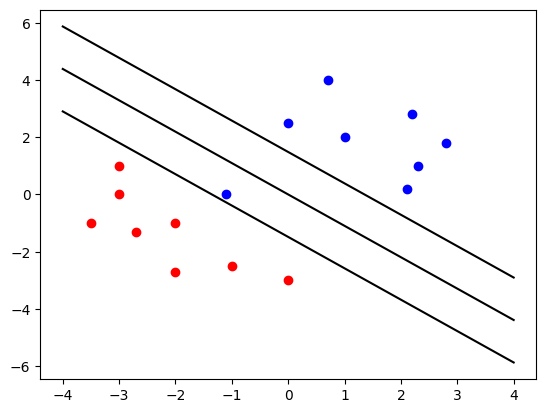

In [6]:
# Write your code here
xl = np.linspace(-4, 4, 100)
yl = -Wo[0]/Wo[1]*xl - bo/Wo[1]
yl_1 = -Wo[0]/Wo[1]*xl - (bo+np.sqrt(Wo[0]**2+Wo[1]**2))/Wo[1]
yl_2 = -Wo[0]/Wo[1]*xl - (bo-np.sqrt(Wo[0]**2+Wo[1]**2))/Wo[1]
plot_points(X, y)
plt.plot(xl, yl, 'k-')
plt.plot(xl, yl_1, 'k-')
plt.plot(xl, yl_2, 'k-')

plt.show()


In the next cell add the following points:
* (-4, -10) with label 1
* (4, 4) with label -1

Is the decision boundary changed after adding the points? Plot it. Explain your observations theoretically.

In [7]:
# Re-create the Synthetic Data by adding the points and visualize the points
X_new = X.tolist()
Y_new = y.tolist()
X_new.append([-4,-10])
Y_new.append(1)
X_new.append([4,4])
Y_new.append(-1)
X_new=np.array(X_new)
Y_new=np.array(Y_new)
X_new,Y_new
n,d = X_new.shape
w = cp.Variable(d)
b = cp.Variable()
obj = cp.Minimize(0.5*cp.square(cp.norm(w)))
constraints = [cp.matmul(Y_new,(X_new@w + b)) >= 1]
prob = cp.Problem(obj, constraints)
prob.solve()
Wo = w.value
bo = b.value
print("Optimal value of W:", Wo)
print("Optimal value of B:", bo)

Optimal value of W: [-0.01282575 -0.01413747]
Optimal value of B: 0.0


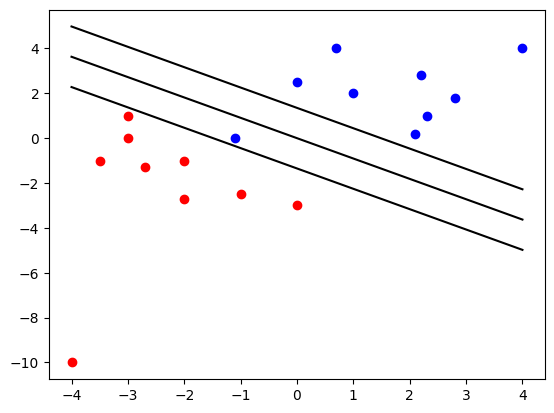

In [8]:
# Solve for the decision boundary using this modified dataset
xl = np.linspace(-4, 4, 100)
yl = -Wo[0]/Wo[1]*xl - bo/Wo[1]
yl_1 = -Wo[0]/Wo[1]*xl - (bo+np.sqrt(Wo[0]**2+Wo[1]**2))/Wo[1]
yl_2 = -Wo[0]/Wo[1]*xl - (bo-np.sqrt(Wo[0]**2+Wo[1]**2))/Wo[1]
plot_points(X_new, Y_new)
plt.plot(xl, yl, 'k-')
plt.plot(xl, yl_1, 'k-')
plt.plot(xl, yl_2, 'k-')

plt.show()

In the next cell you are required to modify your framing of optimisation problem to incorporate soft constraints also known as slack. Plot the decision boundary, w and margin lines for various values of C: $0.01$, $0.1$, $3$, $10$, $100$.

Explain your results theoretically. How does the boundary change with varying values of C? Why?

**Note: Use the modified X and y i.e after adding points in previous cell**

Optimal value of W: [-0.01282574 -0.01413747]
Optimal value of B: 0.0


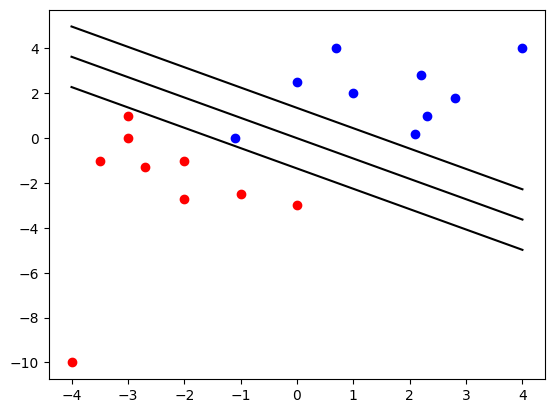

In [9]:
# Write your code here for C= 0.01
C= 0.01
w = cp.Variable(d)
b = cp.Variable()
psi = cp.Variable(n)
obj = cp.Minimize(0.5*cp.square(cp.norm(w))+ C*cp.sum(psi))
constraints = [cp.matmul(Y_new,(X_new@w + b)) >= 1-psi, psi>=0]
prob = cp.Problem(obj, constraints)
prob.solve()
Wo = w.value
bo = b.value
print("Optimal value of W:", Wo)
print("Optimal value of B:", bo)
# Solve for the decision boundary using this modified dataset
xl = np.linspace(-4, 4, 100)
yl = -Wo[0]/Wo[1]*xl - bo/Wo[1]
yl_1 = -Wo[0]/Wo[1]*xl - (bo+np.sqrt(Wo[0]**2+Wo[1]**2))/Wo[1]
yl_2 = -Wo[0]/Wo[1]*xl - (bo-np.sqrt(Wo[0]**2+Wo[1]**2))/Wo[1]
plot_points(X_new, Y_new)
plt.plot(xl, yl, 'k-')
plt.plot(xl, yl_1, 'k-')
plt.plot(xl, yl_2, 'k-')

plt.show()

Optimal value of W: [-0.01282575 -0.01413747]
Optimal value of B: 0.0


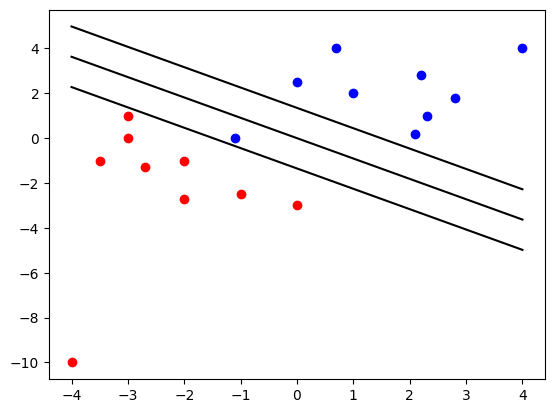

In [10]:
# Write your code here for C= 0.1
C= 0.1
w = cp.Variable(d)
b = cp.Variable()
psi = cp.Variable(n)
obj = cp.Minimize(0.5*cp.square(cp.norm(w))+ C*cp.sum(psi))
constraints = [cp.matmul(Y_new,(X_new@w + b)) >= 1-psi, psi>=0]
prob = cp.Problem(obj, constraints)
prob.solve()
Wo = w.value
bo = b.value
print("Optimal value of W:", Wo)
print("Optimal value of B:", bo)
# Solve for the decision boundary using this modified dataset
xl = np.linspace(-4, 4, 100)
yl = -Wo[0]/Wo[1]*xl - bo/Wo[1]
yl_1 = -Wo[0]/Wo[1]*xl - (bo+np.sqrt(Wo[0]**2+Wo[1]**2))/Wo[1]
yl_2 = -Wo[0]/Wo[1]*xl - (bo-np.sqrt(Wo[0]**2+Wo[1]**2))/Wo[1]
plot_points(X_new, Y_new)
plt.plot(xl, yl, 'k-')
plt.plot(xl, yl_1, 'k-')
plt.plot(xl, yl_2, 'k-')

plt.show()

Optimal value of W: [-0.01282579 -0.01413752]
Optimal value of B: 0.0


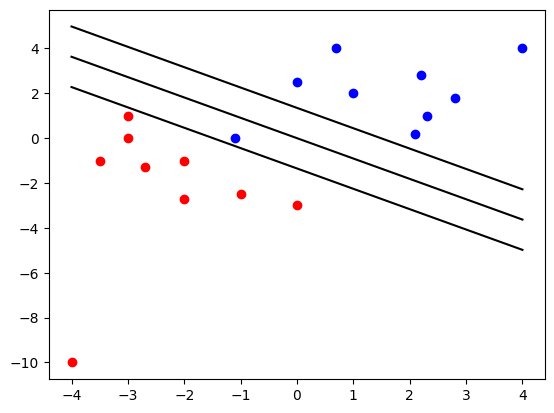

In [11]:
# Write your code here for C= 3
C= 3
w = cp.Variable(d)
b = cp.Variable()
psi = cp.Variable(n)
obj = cp.Minimize(0.5*cp.square(cp.norm(w))+ C*cp.sum(psi))
constraints = [cp.matmul(Y_new,(X_new@w + b)) >= 1-psi, psi>=0]
prob = cp.Problem(obj, constraints)
prob.solve()
Wo = w.value
bo = b.value
print("Optimal value of W:", Wo)
print("Optimal value of B:", bo)
# Solve for the decision boundary using this modified dataset
xl = np.linspace(-4, 4, 100)
yl = -Wo[0]/Wo[1]*xl - bo/Wo[1]
yl_1 = -Wo[0]/Wo[1]*xl - (bo+np.sqrt(Wo[0]**2+Wo[1]**2))/Wo[1]
yl_2 = -Wo[0]/Wo[1]*xl - (bo-np.sqrt(Wo[0]**2+Wo[1]**2))/Wo[1]
plot_points(X_new, Y_new)
plt.plot(xl, yl, 'k-')
plt.plot(xl, yl_1, 'k-')
plt.plot(xl, yl_2, 'k-')

plt.show()

Optimal value of W: [-0.0128258  -0.01413753]
Optimal value of B: 0.0


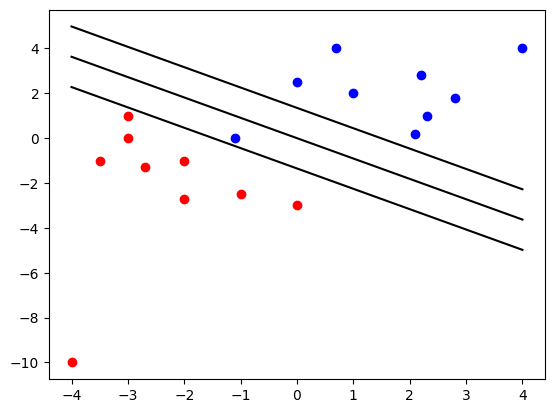

In [12]:
# Write your code here for C= 10
C= 10
w = cp.Variable(d)
b = cp.Variable()
psi = cp.Variable(n)
obj = cp.Minimize(0.5*cp.square(cp.norm(w))+ C*cp.sum(psi))
constraints = [cp.matmul(Y_new,(X_new@w + b)) >= 1-psi, psi>=0]
prob = cp.Problem(obj, constraints)
prob.solve()
Wo = w.value
bo = b.value
print("Optimal value of W:", Wo)
print("Optimal value of B:", bo)
# Solve for the decision boundary using this modified dataset
xl = np.linspace(-4, 4, 100)
yl = -Wo[0]/Wo[1]*xl - bo/Wo[1]
yl_1 = -Wo[0]/Wo[1]*xl - (bo+np.sqrt(Wo[0]**2+Wo[1]**2))/Wo[1]
yl_2 = -Wo[0]/Wo[1]*xl - (bo-np.sqrt(Wo[0]**2+Wo[1]**2))/Wo[1]
plot_points(X_new, Y_new)
plt.plot(xl, yl, 'k-')
plt.plot(xl, yl_1, 'k-')
plt.plot(xl, yl_2, 'k-')

plt.show()

Optimal value of W: [-0.01282577 -0.01413749]
Optimal value of B: 0.0


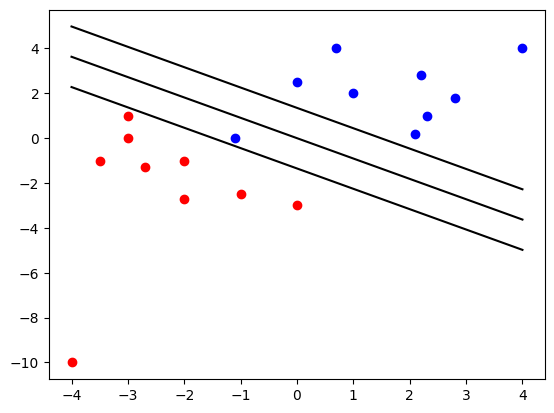

In [13]:
# Write your code here for C= 100
C= 100
w = cp.Variable(d)
b = cp.Variable()
psi = cp.Variable(n)
obj = cp.Minimize(0.5*cp.square(cp.norm(w))+ C*cp.sum(psi))
constraints = [cp.matmul(Y_new,(X_new@w + b)) >= 1-psi, psi>=0]
prob = cp.Problem(obj, constraints)
prob.solve()
Wo = w.value
bo = b.value
print("Optimal value of W:", Wo)
print("Optimal value of B:", bo)
# Solve for the decision boundary using this modified dataset
xl = np.linspace(-4, 4, 100)
yl = -Wo[0]/Wo[1]*xl - bo/Wo[1]
yl_1 = -Wo[0]/Wo[1]*xl - (bo+np.sqrt(Wo[0]**2+Wo[1]**2))/Wo[1]
yl_2 = -Wo[0]/Wo[1]*xl - (bo-np.sqrt(Wo[0]**2+Wo[1]**2))/Wo[1]
plot_points(X_new, Y_new)
plt.plot(xl, yl, 'k-')
plt.plot(xl, yl_1, 'k-')
plt.plot(xl, yl_2, 'k-')

plt.show()

Take the case of C = 100 and remove the support vectors. Does the boundary change after the deletion? Explain why?

Optimal value of W: [1.29810156e-08 1.54357913e-08]
Optimal value of B: 49.013785329490965


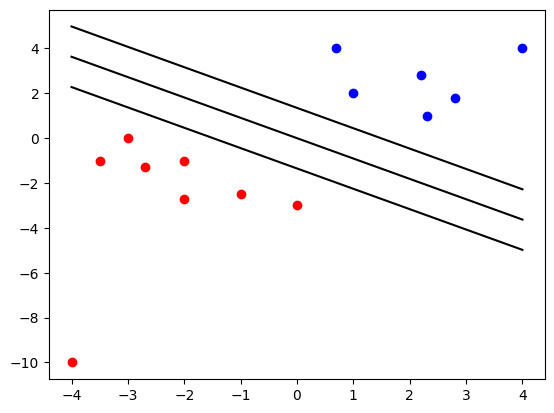

[[ -3.5  -1. ]
 [ -3.    0. ]
 [ -2.7  -1.3]
 [ -2.   -1. ]
 [ -2.   -2.7]
 [ -1.   -2.5]
 [  0.   -3. ]
 [  1.    2. ]
 [  0.7   4. ]
 [  2.3   1. ]
 [  2.8   1.8]
 [  2.2   2.8]
 [ -4.  -10. ]
 [  4.    4. ]]


In [14]:
# Write your Code here
x_n = np.delete(X_new, [2,8,9,12],axis=0)
y_n= np.delete(Y_new, [2,8,9,12],axis=0)
# x_n=X_new
# y_n=Y_new
C= 100
n, d = x_n.shape
w =  cp.Variable(d)
b = cp.Variable()
psi = cp.Variable(n)
obj = cp.Minimize(0.5*cp.square(cp.norm(w))+ C*cp.sum(psi))
constraints = [cp.matmul(y_n,(x_n@w + b)) >= 1-psi, psi>=0]
prob = cp.Problem(obj, constraints)
prob.solve()
Wo = w.value
bo = b.value
print("Optimal value of W:", Wo)
print("Optimal value of B:", bo)
# Solve for the decision boundary using this modified dataset
xl = np.linspace(-4, 4, 100)
yL = -Wo[0]/Wo[1]*xl - bo/Wo[1]
yL_1 = -Wo[0]/Wo[1]*xl - (bo+np.sqrt(Wo[0]**2+Wo[1]**2))/Wo[1]
yL_2 = -Wo[0]/Wo[1]*xl - (bo-np.sqrt(Wo[0]**2+Wo[1]**2))/Wo[1]
plot_points(x_n, y_n)
plt.plot(xl, yl, 'k-')
plt.plot(xl, yl_1, 'k-')
plt.plot(xl, yl_2, 'k-')

plt.show()

print(x_n)

#### Observation
 the decision boundary will shift and may become less accurate. This is because the remaining support vectors are not be able to fully capture the complexity of the data and the decision boundary may not generalize well to new, unseen data. But the removing noisy point like (-1.1,0) boundary may become more accurate and generalize better to new data 

### Subsection 2

In [15]:
!pip install python-mnist
!rm -rf samples
!mkdir samples
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz -P samples/
!gunzip samples/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz -P samples/
!gunzip samples/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz -P samples/
!gunzip samples/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz -P samples/
!gunzip samples/t10k-labels-idx1-ubyte.gz


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
--2023-03-26 19:14:03--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.21.29.36, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘samples/train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  5.02MB/s    in 1.9s    

2023-03-26 19:14:05 (5.02 MB/s) - ‘samples/train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2023-03-26 19:14:06--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3036::ac43:ab4c, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response.

In [16]:
# Import Relevant Packages
from sklearn.svm import SVC
import numpy as np
from mnist.loader import MNIST

In [17]:
mndata = MNIST('samples')

# Load training dataset
images, labels = mndata.load_training()
l = len(labels)
images_train = np.array(images)
labels_train = np.array(labels)

print(images_train.shape)
print(labels_train.shape)

(60000, 784)
(60000,)


In [18]:
# Load testing dataset
images, labels = mndata.load_testing()
l = len(labels)
images_test = np.array(images)
labels_test = np.array(labels)

print(images_test.shape)
print(labels_test.shape)

(10000, 784)
(10000,)


- Tweak different parameters like the C Parameter and gamma parameter of the Linear SVM and report the results.
- Experiment different kernels (Linear, Polynomial, RBF, Sigmoid) for classification and report the results.

Report accuracy score, F1-score, Confusion matrix and any other metrics you feel useful.

In [19]:
# use this subset of data for training and testing

batch = 3000
X_train = images_train[:batch,:]
y_train = labels_train[:batch]

X_test = images_test[batch:2*batch,:]
y_test = labels_test[batch:2*batch]

In [20]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3000, 784)
(3000,)
(3000, 784)
(3000,)


In [21]:
# SVM Classifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sb

C=[0.01,0.1,1,10,100]
kernel=['linear','poly','rbf','sigmoid']
acc = np.zeros((len(C),len(kernel)))
f1 = np.zeros((len(C),len(kernel)))
for c in C:
    for k in kernel:
        clf = svm.SVC(C=c,kernel=k)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc[C.index(c)][kernel.index(k)] = accuracy_score(y_test, y_pred)
        f1[C.index(c)][kernel.index(k)] = f1_score(y_test, y_pred, average='macro')
        conf_mat = confusion_matrix(y_test, y_pred)
        print("Accuracy for C=",c," and kernel=",k," is ",acc[C.index(c)][kernel.index(k)])
        print("F1 score for C=",c," and kernel=",k," is ",f1[C.index(c)][kernel.index(k)])
        print("Confusion Matrix for C=",c," and kernel=",k," is ",conf_mat,'\n')
        
        
        
        

Accuracy for C= 0.01  and kernel= linear  is  0.8893333333333333
F1 score for C= 0.01  and kernel= linear  is  0.8875178765373523
Confusion Matrix for C= 0.01  and kernel= linear  is  [[288   0   4   0   1   1   1   1   1   0]
 [  0 339   1   2   0   1   2   1   0   0]
 [  3   5 286   6   4   0   1   4   3   0]
 [  3   2   8 237   0  18   0   3   5   3]
 [  1   1   5   0 250   0   3   1   0  20]
 [  3   2   1  14   1 226   2   3  11   2]
 [  6   0   8   0   7   6 260   2   1   0]
 [  0   4  10   5   2   0   1 259   2  20]
 [  4   3   2  13   6  19   3   2 245   4]
 [  2   5   3   7  18   1   0  11   1 278]] 

Accuracy for C= 0.01  and kernel= poly  is  0.375
F1 score for C= 0.01  and kernel= poly  is  0.3916011767653312
Confusion Matrix for C= 0.01  and kernel= poly  is  [[171 121   0   0   2   0   3   0   0   0]
 [  0 346   0   0   0   0   0   0   0   0]
 [  0 196 110   3   1   0   0   1   1   0]
 [  0 163   2 113   0   0   0   1   0   0]
 [  0 184   0   0  95   0   2   0   0   0]
 [ 

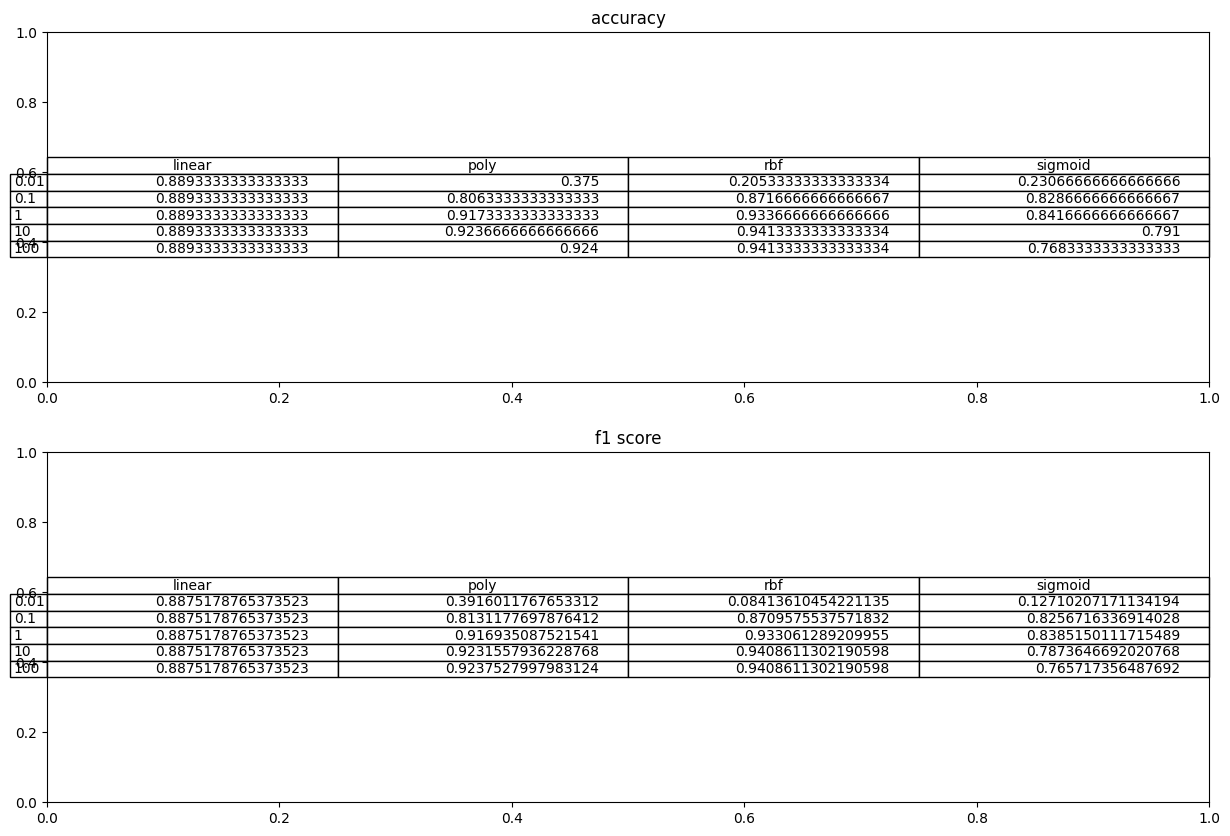

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
axes[0].table(acc, rowLabels=C, colLabels=kernel, loc='center')
axes[0].set_title('accuracy')
axes[1].table(f1, rowLabels=C, colLabels=kernel, loc='center')
axes[1].set_title('f1 score')
plt.show()